# <h1 style="font-size: 52px;">FiguraAI</h1>

By Itai Aviad
<br>Bosmat High School, Haifa

<img src='https://i.imgur.com/LVHMcBE.png' />

<div dir="rtl">
מטרת המחקר היא לעזור לילדים ולאנשים עם בעיות למידה ללמוד צורות שונות על ידי זיהוי צורה שצוירה בכתב יד. 
<br>
המשתמש יצייר צורה באפליקצייה במכשיר הנייד שלו, ויוכל ללמוד על צורות גיאומטריות שונות.
<br><br>
השם FiguraAI הוא שילוב של המילה הלטינית "Figura" שמשמעותה "צורה", והמילה "AI" שמשמעותה "אינטיליגנציה מלאכותית".
</div>

# <h1>Dataset</h1>

Name: **Hand-drawn Shapes (HDS) Dataset**
<br>Link: https://www.kaggle.com/datasets/frobert/handdrawn-shapes-hds-dataset
<br>Creator: Francois Robert
<br>Date: 

The dataset contains images like Rectangles, Ellipses and Triangles, and csv files with the vertices of the shapes.


<br>In the dataset there are 47.3k files (total 60 MB):
* 27.3k `.png` files
* 20.0k `.csv` files

`.png` files: 
hand-drawn images of different shapes with different drawing styles.

`.csv` files: 
contain relative cordinates of vertices of the shapes in the images.
<br>Each csv file contains 4 pairs of relative (x, y) values. The pairs are sorted clockwise from top to left (top, right, bottom, left).

In [2]:
import csv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler

# <h1 dir='rtl' style='text-align: center;' >חקר נתונים</h1>



### <h3 dir='rtl' style='text-align: center;' >יצירת קובץ CSV חדש וטעינת נתונים</h3>

In this part, I rearranged all the `.csv` files into a new combined `.csv` file.

In [ ]:
directories = [name for name in os.listdir(".") if os.path.isdir(name)] # All the subdirectories of the current directory
shapes = ['ellipse', 'rectangle', 'triangle']
print(directories)

['user.aly', 'user.crt', 'user.drt', 'user.elu', 'user.frt', 'user.if1', 'user.if2', 'user.if3', 'user.if5', 'user.if8', 'user.il1', 'user.ilb', 'user.im1', 'user.lrt', 'user.lt1', 'user.lts', 'user.mrt', 'user.nae', 'user.nld', 'user.u01', 'user.u02', 'user.u03', 'user.u04', 'user.u05', 'user.u06', 'user.u07', 'user.u08', 'user.u09', 'user.u10', 'user.u11', 'user.u12', 'user.u13', 'user.u14', 'user.u17', 'user.u18', 'user.u19', 'user.vly']


In [ ]:
# Add the columns names to the csv file
with open('cords.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    columns = ['label', 'topX', 'topY', 'rightX', 'rightY', 'bottomX', 'bottomY', 'leftX', 'leftY' ]
    writer.writerow(columns)

In [ ]:
# Combine all the different csv files to the new cords.csv file
with open('cords.csv', 'a', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    for folder in directories:
        for shape in shapes:
            labal = shape
            
            if(os.path.exists(f'./data/{folder}/vertices/{shape}')):
                csv_files = os.listdir(f'./data/{folder}/vertices/{shape}')

                for file in csv_files:
                    data = pd.read_csv(f'./data/{folder}/vertices/{shape}/{file}')

                    try:
                        data = pd.DataFrame(np.vstack([data.columns, data])).astype('float')
                        data = np.insert(data.values, 0, shapes.index(shape))

                        writer.writerow(data)
                    except ValueError:
                        continue

### <h3 dir='rtl' style='text-align: center;' >קריאת הנתונים המסודרים</h3>

In [4]:
cords = pd.read_csv("./cords.csv")
cords.head()
# 0.0 = ellipse
# 1.0 = rectangle
# 2.0 = triangle

,label,topX,topY,rightX,rightY,bottomX,bottomY,leftX,leftY
0,0.0,0.49,0.11,0.60,0.50,0.49,0.88,0.40,0.49
1,0.0,0.49,0.11,0.76,0.49,0.49,0.87,0.22,0.49
2,0.0,0.11,0.52,0.48,0.31,0.89,0.48,0.51,0.69
3,0.0,0.49,0.11,0.66,0.48,0.51,0.88,0.33,0.49
4,0.0,0.50,0.11,0.83,0.49,0.50,0.88,0.17,0.49


In [11]:
# Examples of different shape values
cords[0:201:50]

,label,topX,topY,rightX,rightY,bottomX,bottomY,leftX,leftY
0,0.0,0.49,0.11,0.60,0.50,0.49,0.88,0.40,0.49
50,0.0,0.11,0.54,0.49,0.41,0.88,0.46,0.51,0.59
100,1.0,0.17,0.38,0.80,0.38,0.78,0.62,0.15,0.62
150,2.0,0.23,0.83,0.44,0.08,0.76,0.87,0.23,0.83
200,2.0,0.16,0.35,0.86,0.17,0.55,0.84,0.16,0.35


In [ ]:
cords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19968 entries, 0 to 19967
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   label    19968 non-null  float64
 1   topX     19968 non-null  float64
 2   topY     19968 non-null  float64
 3   rightX   19968 non-null  float64
 4   rightY   19968 non-null  float64
 5   bottomX  19968 non-null  float64
 6   bottomY  19968 non-null  float64
 7   leftX    19968 non-null  float64
 8   leftY    19968 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [ ]:
cords.describe()

,label,topX,topY,rightX,rightY,bottomX,bottomY,leftX,leftY
count,19968.000000,19968.000000,19968.000000,19968.000000,19968.000000,19968.000000,19968.00000,19968.000000,19968.000000
mean,1.007212,0.214492,0.598681,0.439140,0.286429,0.773269,0.49797,0.459019,0.684581
std,0.808038,0.121001,0.186111,0.225271,0.131821,0.131793,0.21426,0.258276,0.144045
min,0.000000,0.000000,0.050000,0.010000,0.020000,0.030000,0.05000,0.000000,0.050000
25%,0.000000,0.120000,0.500000,0.230000,0.160000,0.700000,0.35000,0.190000,0.580000
50%,1.000000,0.160000,0.600000,0.470000,0.300000,0.830000,0.49000,0.490000,0.680000
75%,2.000000,0.290000,0.740000,0.560000,0.390000,0.870000,0.65000,0.660000,0.820000
max,2.000000,0.880000,0.990000,0.950000,0.950000,0.990000,0.96000,0.960000,0.990000


In [ ]:
cords['label'].value_counts()

1.0    6930
2.0    6591
0.0    6447
Name: label, dtype: int64

In [ ]:
cords.nunique()

label       3
topX       88
topY       94
rightX     94
rightY     89
bottomX    94
bottomY    91
leftX      95
leftY      94
dtype: int64

### <h3 dir='rtl' style='text-align: center;' >ויזואליזציה של הנתונים</h3>

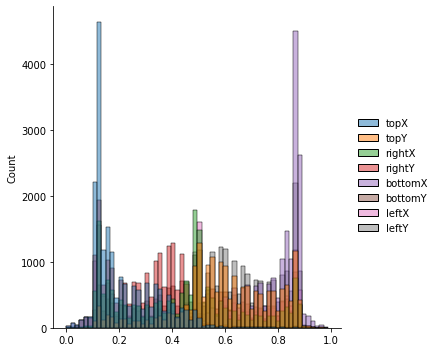

In [7]:
# Count of unique values per coordinate
sns.displot(cords.iloc[:, 1:]) # All values, column 1-8

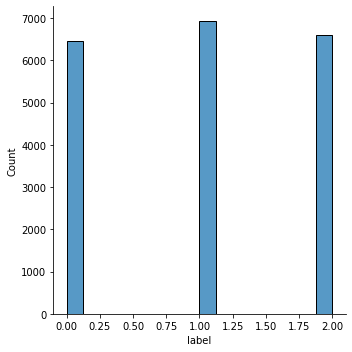

In [ ]:
# Count of labels per shape
sns.displot(cords.iloc[:, 0]) # All values, column 0

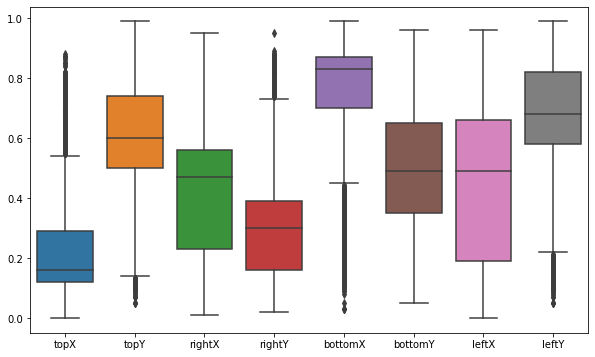

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=cords.iloc[:, 1:])

Text(0, 0.5, 'bottomY')

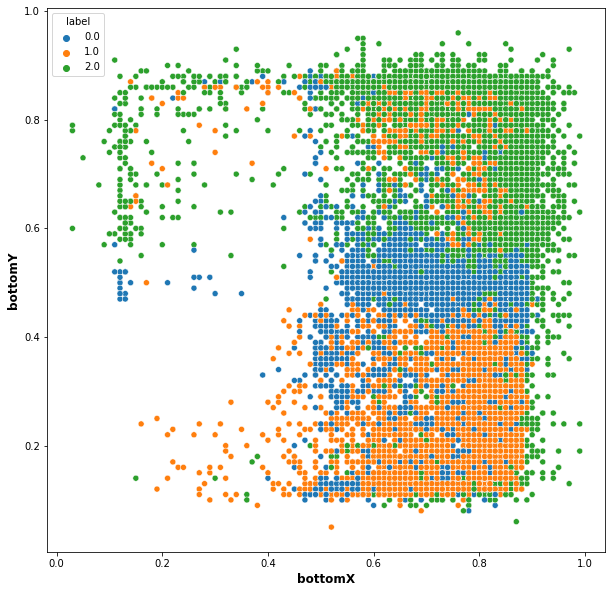

In [ ]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=cords['bottomX'], y=cords['bottomY'], hue=cords['label'], palette=["C0", "C1", "C2"])
plt.xlabel("bottomX", fontsize=12, fontweight='bold')
plt.ylabel("bottomY", fontsize=12, fontweight='bold')

# <h1 dir='rtl' style='text-align: center;' >למידת מכונה</h1>

### <h3 dir='rtl' style='text-align: center;' >חלוקת הנתונים ל2 חלקים ואימון אלגוריתם KNN</h3>

In [5]:
# Spliting to Lables and Values
X = cords.drop(['label'], axis=1).to_numpy()
y = cords['label'].to_numpy()
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (19968, 8)
y shape: (19968,)


In [6]:
# Spliting to Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("train:\n\tX:", X_train.shape, "\n\ty:", y_train.shape)
print("test: \n\tX:" , X_test.shape, "\n\ty:", y_test.shape)

train:
	X: (15974, 8) 
	y: (15974,)
test: 
	X: (3994, 8) 
	y: (3994,)


In [ ]:
# Training the model
KNN = KNeighborsClassifier(n_neighbors=5)
KNN.fit(X_train, y_train)

KNeighborsClassifier()

### <h3 dir='rtl' style='text-align: center;' >בחינת ביצועים</h3>

In [ ]:
# Score test
score = KNN.score(X_test, y_test)
print("score:", score)  

score: 0.9954932398597897


In [ ]:
# Confusion matrix test
y_pred = KNN.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[1296,    5,    1],
       [  10, 1456,    0],
       [   0,    2, 1224]])

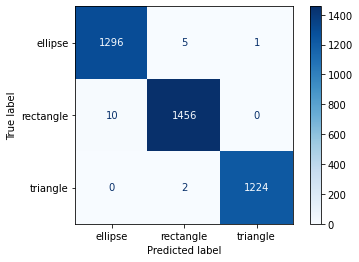

In [ ]:
# Confusion matrix test display
ConfusionMatrixDisplay.from_estimator(KNN, X_test, y_test, values_format="d", cmap='Blues', display_labels=shapes)

In [ ]:
# More scores
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

         0.0     0.9923    0.9954    0.9939      1302
         1.0     0.9952    0.9932    0.9942      1466
         2.0     0.9992    0.9984    0.9988      1226

    accuracy                         0.9955      3994
   macro avg     0.9956    0.9956    0.9956      3994
weighted avg     0.9955    0.9955    0.9955      3994



# <h1 dir='rtl' style='text-align: center;' >סיכום</h1>

### <h3 dir='rtl' style='text-align: center;' >סיכום העבודה - מסקנות לגבי הנתונים והאלגוריתם</h3>

<div dir='rtl'>
הנתונים:
<br>בהתחלה, הנתונים נראו לא נוחים לעבודה בגלל שהיו מסודרים באלפי קבצי <code dir='ltr' >.csv</code> קטנים לכל אחד מהתמונות, אך לאחר סידור הנתונים בקובץ <code dir='ltr' >.csv</code> חדש, הנתונים התגלו כנוחים לעבודה.
<br><br>
בתוך הדאטה, יש שני סוגי קבצים:
<br>
* בתוך הדאטה סט ישנן אלפי תמנות שחור לבן בגודל קבוע של 70 פיקסלים על 70 פיקסלים (70X70) שבהן מצוירות צורות שונות הכוללות, אליפסות ומעגלים, מרובעים ומלבנים, ומשולשים שונים.
כל התמונות מצוירות בכתב יד בסגנונות שונים, לבן על גבי שחור, כדי שלמודל יהיה יותר קל להתאמן ולזהות את הצורות.
<br>
* בנוסף לכך, בדאטה סט יש אלפי קבצי <code dir='ltr' >.csv</code> שבכל אחד מהם מסודרים 4 זוגות של קורדינאטות המביעות את מיקום הקודקודים באופן יחסי (כלומר האחוז מכלל הפיקסלים בו נמצא הקודקוד) ולכל זוג קורדינאטות יש ערך x וערך y.
<br><br>
האלגוריתם:
<br>
אלגוריתם האימון KNN מספריית sklearn היה נוח לשימוש עם הנתונים שבחרתי, ונתן תוצאות דיוק גבוהות מאוד.
<br>
האלגוריתם מקבל שני dataframes שונים, train ו test. ה dataframes מסודרים על פי labels ונתונים, כאשר הנתונים מביעים את תכונות האיבר שמופיע ב label.
<br>
כמו כן, האלגוריתם מקבל היפר-פרמטר שמסומן על ידי האות k, שמביעה את מספר ה"שכנים" בהם האלגוריתם משתמש כדי לנבע את התוצאה.

</div>

### <h3 dir='rtl' style='text-align: center;' >רפקלציה</h3>

<div dir='rtl' >
תהליך הלמידה היה כיף ולמדתי כמה דברים חדשים.
<br>
ראשית, למדתי כיצד להשתמש בספריות python שונות לסידור, ניקוי ושימוש בנתונים, ספריות ליצירת והצגת גרפים שונים ותוצאות שונות וספריות לחילוק נתונים ואימון מודלים.
<br>
כמו כן, למדתי על אלגוריתם KNN וכיצד להשתמש בו לאימון מודל למידת מכונה, וכיצד לבדוק את אמינותו ודיוקו.
<br>
למדתי על נוסחאות שונות לבדיקת דיוק המודל כמו socre, precision, recall ו f1, בנוסף לטבלת דיוק ניבוי האלגוריתם  confusion matrix.
</div>